In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
from datetime import date, timedelta

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
measurement=Base.classes.measurement
station=Base.classes.station
session=Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [5]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [6]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
mostrecentdate=dt.datetime.strptime((session.query(measurement.date).order_by(measurement.date.desc()).\
                                     first())[0],'%Y-%m-%d').date()
twelvemonthsago = mostrecentdate-dt.timedelta(days=365)
yearof_temps= calc_temps(twelvemonthsago, mostrecentdate)
yearof_temps

[(58.0, 74.59058295964125, 87.0)]

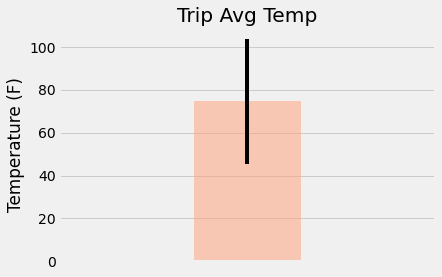

In [7]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df = pd.DataFrame(yearof_temps, columns=["temp min", "temp avg", "temp max"])
df["temp avg"].plot(kind='bar', yerr=(df["temp max"]-df["temp min"]),width = 0.2, color='Lightsalmon',alpha = 0.5).\
axes.get_xaxis().set_visible(False)
plt.title("Trip Avg Temp")
plt.ylabel('Temperature (F)')
plt.show()


### Daily Rainfall Average

In [8]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
data =[station.station, station.name, station.latitude, station.longitude, station.elevation, func.sum(measurement.prcp)]
#trip days
startdate = '2017-06-15'
enddate = '2017-06-30'
rainfall=pd.DataFrame(session.query(*data).filter(measurement.station==station.station).\
group_by(measurement.station).\
    filter(measurement.date >= startdate).\
    filter(measurement.date <= enddate).\
    order_by(func.sum(measurement.prcp).desc()).all(), columns=["Station id", "Station name", "latitude","longitude",'elevation', 'total precipitation'])
rainfall

,Station id,Station name,latitude,longitude,elevation,total precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,5.48
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.83
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.19
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.88
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.21
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.13
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.12


### Daily Temperature Normals

In [9]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [10]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
startdate = '2023-06-15'
enddate = '2023-06-30'

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d
vacay_list= pd.date_range(start= startdate,end= enddate).strftime("%m-%d").tolist()
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals =pd.DataFrame([daily_normals(date)[0] for date in vacay_list],columns=['tmin','tavg','tmax'],index=[vacay_list])

normals

,tmin,tavg,tmax
06-15,67.0,75.403509,81.0
06-16,69.0,75.413793,81.0
06-17,68.0,74.593220,81.0
06-18,69.0,74.603448,80.0
06-19,70.0,75.440678,82.0
06-20,68.0,73.964912,85.0
06-21,68.0,74.758621,82.0
06-22,69.0,75.157895,81.0
06-23,68.0,74.543860,80.0
06-24,68.0,74.964286,84.0


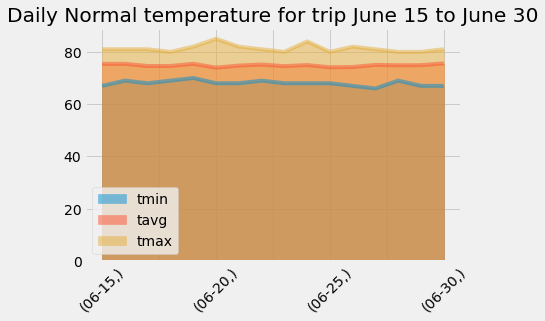

In [11]:
# Plot the daily normals as an area plot with `stacked=False`
normals.plot.area(stacked=False, title="Daily Normal temperature for trip June 15 to June 30")
plt.xticks(rotation=45)
plt.show()

## Close Session

In [12]:
session.close()